In [11]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Customers Leaving Beta Bank

Lots of customers are leaving the bank, predict how many will leave. Download the customer data and preprocess is to create different models. Improve the models to find which one will best suit the data, then find the total customers predicted to leave the bank.

## Data Preprocessing

In [12]:
data = pd.read_csv('/datasets/Churn.csv')

In [13]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [15]:
# Some of the tenure data is missing, so we'll fill it with the median of those values
data.loc[data['Tenure'].isna(),'Tenure'] = data['Tenure'].median()

In [16]:
# once we perform OHE, there will be a bunch of surname features making the data difficult to visualize
# The surname column isn't relevant to our analysis, so it can be dropped
data = data.drop('Surname', axis=1)

In [36]:
# check if any of the customers data was duplicated
data['CustomerId'].duplicated().sum()

0

0    7963
1    2037
Name: Exited, dtype: int64

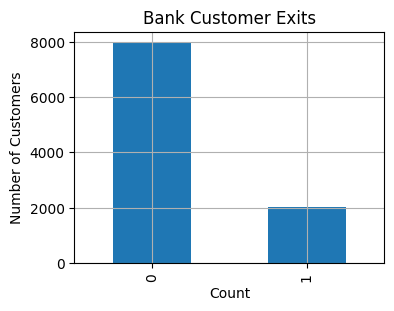

In [41]:
class_frequency = data['Exited'].value_counts()
class_frequency.plot(kind='bar', title='Bank Customer Exits', xlabel='Count' , ylabel='Number of Customers', figsize=[4, 3], grid=True)
class_frequency

Out of 10,000 customers, 2037 of them have left the bank. Just slightly above 20% of Beta Banks customers are recorded as exited the bank. The ratio of those who have not left the bank to those who have is 11-3.

In [18]:
# One-Hot encoding is performed on the dataset and placed in the data_ohe variable
# drop_first=True parameter is used to avoid the dummy trap
data_ohe = pd.get_dummies(data, drop_first=True)

In [19]:
data_ohe.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [20]:
# declare the target as the 'Exited' column and everything else as features
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [21]:
# the dataset needs to be split into three different set, one for training(60%),
# one for validation, and one for final testing(both 20%)
# the first split gives us a training set of 60% and 'other' set of 40% to later be split
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345)

# here the 'other' dataset, of 40% the original, is split in half to get is 20% for 'valid'  set, and 20% for 'test' set
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state=12345)

In [22]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 13)
(2000, 13)
(2000, 13)


In [23]:
# Standardize so all features are considered equal
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Balance and Training

The negative values are those of which the 'Exited' target feature is equal to 0 which means the customer has not left. A value of 1 means the customer has left. To find find the imbalance of the datasets, the percentage of each target value is found. All of the sets are very similar sitting around 80% for each negative target value, and around 20% for each positive target value.

In [24]:
print('Training Set')
print(f'Negative class : {round(target_train[target_train == 0].count() * 100 / len(target_train), 2)}%') 
print(f'Positive class : {round(target_train[target_train == 1].count() * 100 / len(target_train), 2)}%\n') 

print('Validation Set')
print(f'Negative class : {(target_valid[target_valid == 0].count() * 100 / len(target_valid))}%') 
print(f'Positive class : {(target_valid[target_valid == 1].count() * 100 / len(target_valid))}%\n') 

print('Test Set')
print(f'Negative class : {(target_test[target_test == 0].count() * 100 / len(target_test))}%') 
print(f'Positive class : {(target_test[target_test == 1].count() * 100 / len(target_test))}%')

Training Set
Negative class : 80.07%
Positive class : 19.93%

Validation Set
Negative class : 79.1%
Positive class : 20.9%

Test Set
Negative class : 78.85%
Positive class : 21.15%


### Regression Model

In [25]:
# Train the regression model prior to fixing imbalance
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 Score:')
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:')
print(roc_auc_score(target_valid, probabilities_one_valid))

F1 Score:
0.0
AUC-ROC:
0.49305282514411536


The f1 score on the logistic regression modek is very low while the AUC-ROC metric is almost at 0.5 which is pretty average. Next we will see if balancing out the class weight and downsampling will result in better values for both scores.

In [26]:
# Downsample and balance class weight
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+ [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+ [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model = LogisticRegression(class_weight='balanced', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:')
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:')
print(roc_auc_score(target_valid, probabilities_one_valid))

F1 Score:
0.3457402812241522
AUC-ROC:
0.5068624900949074


Down sampling did increase the f1 score to 0.35 and brought the AUC-ROC score up a bit to 0.51. Although both scores increased the f1 score isn't at the required score of 0.59. We will see if upsampling, while still balancing the class weight will increase the scores

In [27]:
# see if upsampling the mode will give better results
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model = LogisticRegression(class_weight='balanced', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1 Score:')
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:')
print(roc_auc_score(target_valid, probabilities_one_valid))

F1 Score:
0.0
AUC-ROC:
0.4930694596507359


Upsampling resulted in a similar result to our original logistic regression model. Lets try out other models to meet the requirements.

### Decision Tree Model

In [28]:
# Train the decision tree model prior to making impovements
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 Score:')
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:')
print(roc_auc_score(target_valid, probabilities_one_valid))

F1 Score:
0.5179856115107915
AUC-ROC:
0.6951620805835991


The decision tree model is much better even without any improvements to it. It's f1 score is 0.52, still just short of the requirement, but its AUC-ROC score is 0.70, higher than the average. Next we'll make some changes to this model to see if it can improve.

In [29]:
# find best depth and upsample the decision tree model
best_model2 = None
best_result2 = 0
best_depth2 = 0

for depth in range(1, 10):
    model2 = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model2.fit(features_upsampled, target_upsampled) 
    predictions_valid2 = model2.predict(features_valid) 
    f1 = f1_score(target_valid, predictions_valid2)
    
    if f1 > best_result2:
        best_model2 = model2
        best_result2 = f1
        best_depth2 = depth
        
probabilities_valid = best_model2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_model2)
print('Best F1 Score:', best_result2)
print('AUC-ROC Score:', auc_roc)
print('Best Depth:', best_depth2)

Best Model: DecisionTreeClassifier(max_depth=7, random_state=12345)
Best F1 Score: 0.5175370226032736
AUC-ROC Score: 0.8048727006575167
Best Depth: 7


Upsampling and finding the best depth for the decision tree hardly changed the f1 score, but the AUC-ROC score improved to 0.80. After looping through different depths, it was found that a depth of 7 was the best for this model. Lets see if downsampling, while still finding the best depth will improve the results of the model.

In [30]:
# find best depth and downsample to see if there are better results
best_model2 = None
best_result2 = 0
best_depth2 = 0

for depth in range(1, 10):
    model2 = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model2.fit(features_downsampled, target_downsampled) 
    predictions_valid2 = model2.predict(features_valid) 
    f1 = f1_score(target_valid, predictions_valid2)
    
    if f1 > best_result2:
        best_model2 = model2
        best_result2 = f1
        best_depth2 = depth
        
probabilities_valid = best_model2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_model2)
print('Best F1 Score:', best_result2)
print('AUC-ROC Score:', auc_roc)
print('Best Depth:', best_depth2)

Best Model: DecisionTreeClassifier(max_depth=8, random_state=12345)
Best F1 Score: 0.49241877256317684
AUC-ROC Score: 0.7491077855539896
Best Depth: 8


Downsampling gave us worse results for the f1 score at 0.49. Although the AUC-ROC score is lower as well, it is still a good score at 0.75. The best depth was 8 for the downsampled version of the decision tree model. Next, lets see if te random forest model will help us reach the required f1 score.

### Random Forest Model

In [31]:
# Train the random forest model prior to making impovements
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 Score:')
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('AUC-ROC:')
print(roc_auc_score(target_valid, probabilities_one_valid))

F1 Score:
0.5598755832037325
AUC-ROC:
0.8393840090975629


The random forest model without any improvements gave us the best results of 0.56 for the f1 score, and 0.84 for the AUC-ROC score. Lets first try downsampling, finding the best depth, and finding the best estimators to get a higher f1 score.

In [32]:
# Downsample, find best depth, and best estimators for random forest model
best_model3 = None
best_result3 = 0
best_depth3 = 0
best_est = 0

for est in range(1, 50):
     for depth in range (1, 50):
        model3 = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        model3.fit(features_downsampled, target_downsampled)
        predictions_valid3 = model3.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid3)
        
        if f1 > best_result3:
            best_model3 = model3
            best_result3 = f1
            best_depth3 = depth
            best_est = est

probabilities_valid = best_model3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_model3)
print('Best F1 Score:', best_result3)
print('AUC-ROC Score:', auc_roc)
print('Best Depth:', best_depth3)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=15, n_estimators=4, random_state=12345)
Best F1 Score: 0.48801742919389973
AUC-ROC Score: 0.7578257792510237
Best Depth: 15
Best n_estimators: 4


The model was looped with different estimators and depths to get a best depth of 15, and best number of estimators of 4. These parmeters gave us an f1 score of 0.49 and a ROC-AUC score of 0.76. These results are worse than the original random forest model, so we will try upsampling instead.

In [33]:
# Upsample, find best depth, and best estimators for better result on random forest model
best_model3 = None
best_result3 = 0
best_depth3 = 0
best_est = 0

for est in range(1, 50):
     for depth in range (1, 50):
        model3 = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        model3.fit(features_upsampled, target_upsampled)
        predictions_valid3 = model3.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid3)
        
        if f1 > best_result3:
            best_model3 = model3
            best_result3 = f1
            best_depth3 = depth
            best_est = est

probabilities_valid = best_model3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_model3)
print('Best F1 Score:', best_result3)
print('AUC-ROC Score:', auc_roc)
print('Best Depth:', best_depth3)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=17, n_estimators=21, random_state=12345)
Best F1 Score: 0.6057571964956197
AUC-ROC Score: 0.8325222751165926
Best Depth: 17
Best n_estimators: 21


Finally when we upsample the random forest we get above the required f1 score at 0.61. The AUC-ROC score was also good at 0.83. The upssampled model found that 17 was our best depth, while 21 was the best number of estimators. We'll put this into our test set and see the results to predict the number of customers leaving the bank.

## Final Test

In [34]:
model3 = RandomForestClassifier(max_depth=17, random_state=12345, n_estimators=21)
model3.fit(features_upsampled, target_upsampled)
predictions_test = model3.predict(features_test)
f1 = f1_score(target_test, predictions_test)
        
probabilities_test = model3.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('F1 Score:', f1)
print('AUC-ROC Score:', auc_roc)

F1 Score: 0.561314791403287
AUC-ROC Score: 0.8282056932470456


After putting the best parameters for the random forest model, the f1 score came t be 0.56 while the AUC-ROC score is 0.83. The predictions will then be used to calculate how many are actually projected to leave the bank.

In [42]:
total = 0
for prediction in predictions_test:
    if prediction == 1:
        total += 1
print(total)

368


According the the model 368 people will leave the bank out of the 2000 in the test set.

## Conclusion

The data for the customers at Beta Bank was first preprocessed. The data was familiarized, missing values were filled, and certain columns were removed that didn't affect the computer model process. One-hot encoding was performed, while also avoiding the dummy trap. The data was split into a training set, validation set, and test set approprietly. The data was then standardize so no feature to precedent over another.

Three different models were then made; a logistic regression model, a decision tree model, and a random forest model. Each model was first trained without taking into account the imbalance. After each model was modified, the random forest model was found to be the best, passing the required f1 score of 0.59; while also having a AUC-ROC score of 0.83. The parameterx it used to get these results were a number of estimators at 21, and a depth of 17, while also using an upscaled dataset. These parameters were used in the final test set.

After using the parameters just mention in the test set, the models f1 score and AUC-ROC score were very close compared to what they just were for the validation set. The model predicted that of the 2000 people using beta bank in the test set, 368 of them would leave the bank. 